# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data is fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by :citet:`De-Cock.2011`,
covers house prices in Ames, IA from the period of 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


In [399]:
import Flux
using CSV, DataFrames, Statistics, CategoricalArrays
# import torch
# from torch import nn
# from d2l import torch as d2l

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data is altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links to download the data.

To get started, we will [**read in and process the data
using `pandas`**], which we have introduced in :numref:`sec_pandas`.
For convenience, we can download and cache
the Kaggle housing dataset.
If a file corresponding to this dataset already exists in the cache directory and its SHA-1 matches `sha1_hash`, our code will use the cached file to avoid clogging up your internet with redundant downloads.


In [899]:
using HTTP

DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
train_filename = "kaggle_house_pred_train.csv"
test_filename = "kaggle_house_pred_test.csv"

raw_train = CSV.read(HTTP.get(DATA_URL * train_filename).body, DataFrame)
raw_val = CSV.read(HTTP.get(DATA_URL * test_filename).body, DataFrame)
;

The training dataset includes 1460 examples,
80 features, and 1 label, while the validation data
contains 1459 examples and 80 features.


In [900]:
print(size(raw_train))

(1460, 81)

In [901]:
print(size(raw_val))

(1459, 80)

## Data Preprocessing

Let's [**take a look at the first four and last two features
as well as the label (SalePrice)**] from the first four examples.


In [902]:
raw_train[[1, 2, 3, 4], [1, 2, 3, 4, end-1, end]]

Row,Id,MSSubClass,MSZoning,LotFrontage,SaleCondition,SalePrice
,Int64,Int64,String7,String3,String7,Int64
1,1,60,RL,65,Normal,208500
2,2,20,RL,80,Normal,181500
3,3,60,RL,68,Normal,223500
4,4,70,RL,60,Abnorml,140000


We can see that in each example, the first feature is the ID.
This helps the model identify each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, we will remove it from the dataset
before feeding the data into the model.
Besides, given a wide variety of data types,
we will need to preprocess the data before we can start modeling.


Let's start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than on any other.

[**Next we deal with discrete values.**]
This includes features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we previously transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [903]:
function find_categorical_columns(df::DataFrame)
    cat_cols = String[]
    for col in names(df)
        if !(eltype(features[!, col]) === Int64 || eltype(features[!, col]) === Float64)
            push!(cat_cols, col)
        end
    end
    return cat_cols
end

find_categorical_columns (generic function with 1 method)

In [904]:
# No onehot encoding when using Linear Regression!!!

function get_onehot_encoding(df::DataFrame, col::String)
    categories = unique(df[!, col])
    df_new = df[:, []]
    for cat in categories
        col_name = col * "_" * string(cat)
        df_new[!, col_name] = ifelse.(df[!, col] .== cat, 1, 0)
    end
    return df_new
end

get_onehot_encoding (generic function with 1 method)

In [921]:
# Preprocess

# using Flux: onehotbatch

# Remove the ID and label columns
raw_train_preprocess = select(raw_train, Not(:Id))
raw_train_preprocess = select(raw_train_preprocess, Not(:SalePrice))
@show size(raw_train_preprocess)
    
raw_test_preprocess = select(raw_val, Not(:Id))
@show size(raw_test_preprocess)
            
features = vcat(raw_train_preprocess, raw_test_preprocess)
@show size(features)
    
# Type conversion -- the dataframe is python and julia gets different column types

for col in names(features)
    replace!(features[!, col], "NA" => "NaN")
end

features[!,:LotFrontage] = parse.(Float64, features[!,:LotFrontage])
features[!, :MasVnrArea] = parse.(Float64, features[!, :MasVnrArea])
features[!, :GarageYrBlt] = parse.(Float64, features[!, :GarageYrBlt])
features[!, :BsmtFinSF1] = parse.(Float64, string.(features[!, :BsmtFinSF1]))
features[!, :BsmtFinSF2] = parse.(Float64, string.(features[!, :BsmtFinSF2]))
features[!, :BsmtUnfSF] = parse.(Float64, string.(features[!, :BsmtUnfSF]))
features[!, :TotalBsmtSF] = parse.(Float64, string.(features[!, :TotalBsmtSF]))
features[!, :BsmtFullBath] = parse.(Float64, string.(features[!, :BsmtFullBath]))
features[!, :BsmtHalfBath] = parse.(Float64, string.(features[!, :BsmtHalfBath]))
features[!, :GarageCars] = parse.(Float64, string.(features[!, :GarageCars]))
features[!, :GarageArea] = parse.(Float64, string.(features[!, :GarageArea]))

# Standardize numerical columns
numeric_features = names(features[!, [i for i in names(features) if eltype(features[!, i]) === Float64 || eltype(features[!, i]) === Int64]])
@show size(numeric_features)

features = transform!(features, numeric_features .=> (x -> (x .- mean(x)) ./ std(x)) .=> numeric_features)

# Replace NAN numerical features by 0
for feature in numeric_features
    features[!, feature] = replace(features[!, feature], NaN => 0)
end

# Replace discrete features by one-hot encoding
# get_dummies(features, dummy_na=True) => null values are also getting their columns
cat_cols = find_categorical_columns(features)

for col in cat_cols
    features = hcat(features, get_onehot_encoding(features, col))
    features = select!(features, Not(col))
end

@show size(features)

# Save preprocessed features
train = features[1:size(raw_train, 1), :]
train[!, :SalePrice] = raw_train[!, :SalePrice]
val = features[size(raw_train, 1)+1:end, :]
;

size(raw_train_preprocess) = (1460, 79)
size(raw_test_preprocess) = (1459, 79)
size(features) = (2919, 79)
size(numeric_features) = (36,)
size(features) = (2919, 311)


In [922]:
size(train) # should be 331 (some categorical columns are missing -> investigate)

(1460, 312)

You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


## Error Measure

To get started we will train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it provides a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by USD 100,000
when estimating the price of a house in Rural Ohio,
where the value of a typical house is 125,000 USD,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds 4 million USD).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


### Notes:

- TensorLoader in d2l:
```
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)
```

- DataLoader in d2l:
```
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)
```

In [923]:
function get_dataloader(data, batch_size)
    label = "SalePrice"

    # Define a function to convert a DataFrame to a Float32 tensor
    convert(x::DataFrame) = (Matrix(x))
    
    if !(label in names(data))
#         @error "Label not in dataframe!"
        return Flux.Data.DataLoader(convert(data), batchsize=batch_size, shuffle=true)
    end

    # Define the input and output tensors
    X = convert(data[:, Not(label)])  # all columns except the label
    Y = log.(data[:, label])    # logarithm of the label column
    
    # X has to be reshaped ib order to be able to use the dataloader
    X = reshape(X, size(X)[2], size(X)[1])
    Y = reshape(Y, 1, :)
    
    @show size(X)
    @show size(Y)

    # Create a DataLoader object
    return Flux.Data.DataLoader((X, Y), batchsize=batch_size, shuffle=true)
end

get_dataloader (generic function with 1 method)

### Note: 

- `Question` about DataLoader: why doesn't it work with X & Y? [link](https://fluxml.ai/Flux.jl/dev/data/mlutils/)
- `Answer`: X's dimensions were not right, a reshape was necessary

In [924]:
get_dataloader(train, 64) # batch size is the size used in tensorflow example

size(X) = (311, 1460)
size(Y) = (1, 1460)


23-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, shuffle=true, batchsize=64)
  with first element:
  (311×64 Matrix{Float64}, 1×64 Matrix{Float64},)

## $K$-Fold Cross-Validation

You might recall that we introduced [**cross-validation**]
in :numref:`subsec_generalization-model-selection`, where we discussed how to deal
with model selection.
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\mathrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\mathrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


### Notes:

- tensorflow -> contains manual implementation, Julia has built-in k-fold implementation

- Options in Julia for K-Fold Cross-Validation:

    - ScikitLearn.CrossValidation: cross_val_score: [see here](https://docs.juliahub.com/ScikitLearn/tbUuI/0.6.2/man/cross_validation/)
    - MLDataUtils
    - MLUtils
    
- using MLUtils.kfolds()

In [925]:
using MLUtils

# MLUtils.kfolds() usage:
train_idx, val_idx = kfolds(get_dataloader(train, 6), 5)
;

size(X) = (311, 1460)
size(Y) = (1, 1460)


### Notes:

- LinearRegression in d2l:

```
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)
```

- Loss:
```
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)
```

- Optimizer:
```
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)
```

- SGD in [documentation](https://fluxml.ai/Flux.jl/v0.4/training/optimisers.html#Optimiser-Reference-1) but it doesn't seem to exist anymore

- Trainer:
```
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.training = True
        for batch in self.train_dataloader:
            with tf.GradientTape() as tape:
                loss = self.model.training_step(self.prepare_batch(batch))
            grads = tape.gradient(loss, self.model.trainable_variables)
            if self.gradient_clip_val > 0:
                grads = self.clip_gradients(self.gradient_clip_val, grads)
            self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.training = False
        for batch in self.val_dataloader:
            self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
```

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [926]:
size(train)

(1460, 312)

In [929]:
using MLUtils, Random, Distributions

function k_fold(max_epochs, train, k)
    val_loss, models = [], []
    train_data = get_dataloader(train, 64)
    kfolds_train = MLUtils.kfolds(train_data, k)
    
    model = Chain(
        Flux.Dense(311, 64),
        Flux.Dense(64, 1)
        )
    opt = Flux.ADAM() # Better than SGD
    loss(X, y) = Flux.mse(model(X), y)
    
    train_loss = []
    val_loss = []
    models = []
    

    for epoch in 1:max_epochs
        i = 0
        for (train, test) in kfolds_train
            Flux.train!(loss, Flux.params(model), train.data, opt)
            i += 1
            if (i == k)
                train_loss_fold = sum(loss(x, y) for (x, y) in train.data) / length(train.data)
                push!(train_loss, train_loss_fold)
        
                val_loss_fold = sum(loss(x, y) for (x, y) in test.data) / length(test.data)
                push!(val_loss, val_loss_fold)
                
                push!(models, model)
            end
        end
    end

#     # just for curiosity - trying out the other way around    
#     for (train, test) in kfolds_train
#         for epoch in 1:max_epochs
#             Flux.train!(loss, Flux.params(model), train.data, opt)
            
#             if (epoch == max_epochs)
#                 train_loss_fold = sum(loss(x, y) for (x, y) in train.data) / length(train.data)
#                 push!(train_loss, train_loss_fold)
        
#                 val_loss_fold = sum(loss(x, y) for (x, y) in test.data) / length(test.data)
#                 push!(val_loss, val_loss_fold)
                
#                 push!(models, model)
#             end
#         end
#     end
#    # got the same results
    
    average_val_log_mse = sum(val_loss)/length(val_loss) # average validation log mse
    @show average_val_log_mse
    
    return train_loss, val_loss, models
end

k_fold (generic function with 3 methods)

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might just get lucky and find that our validation
performance is no longer representative of the true error.


### Notes:

- Training implementation in python tensorflow: [here](https://d2l.ai/chapter_linear-regression/linear-regression-scratch.html#training)

- Implementation:
```
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.training = True
    for batch in self.train_dataloader:
        with tf.GradientTape() as tape:
            loss = self.model.training_step(self.prepare_batch(batch))
        grads = tape.gradient(loss, self.model.trainable_variables)
        if self.gradient_clip_val > 0:
            grads = self.clip_gradients(self.gradient_clip_val, grads)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.training = False
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1
```
- Usage:
```
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, train, val, k=5, lr=0.01)
```

size(X) = (311, 1460)
size(Y) = (1, 1460)
average_val_log_mse = 12.169549943577323


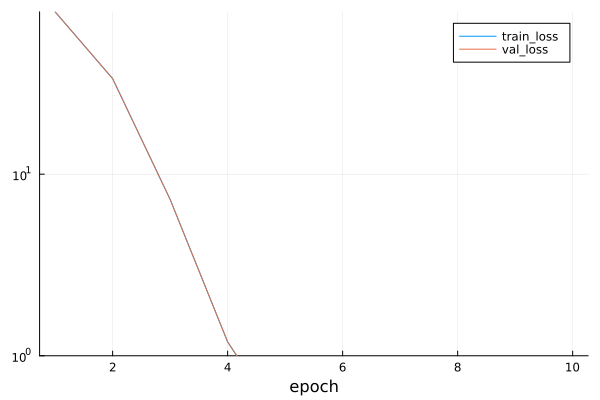

In [930]:
using Plots

max_epochs = 10

train_loss, val_loss, models = k_fold(max_epochs, train, 5)

plot(train_loss, label="train_loss", yaxis = (:log, (1,Inf)))
plot!(val_loss, label="val_loss")
xlabel!("epoch")

In [931]:
size(models)

(10,)

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
is considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might 
calculate the average predictions 
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [932]:
val_matrix = Float64.(Matrix(val))
reshape(val_matrix, 311, :)
;

In [933]:
models[1](val_matrix[5, :])[1]

12.177955f0

In [934]:
using DelimitedFiles

pred_values = [[model(val_matrix[1, :])[1] for model in models]]
for i in 2:size(val)[1]
    push!(pred_values, [model(val_matrix[i, :])[1] for model in models])
end

# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = []
for i in 1:size(val)[1]
    push!(ensemble_preds, Float64.(exp.(mean(pred_values[i]))))
end

submission = DataFrame(Id=raw_val.Id, 
    SalePrice=ensemble_preds)

# CSV.write("submission.csv", submission)
i = 0
open("submission.csv", "w") do io
    writedlm(io, ["Id" "SalePrice"])
    writedlm(io, [raw_val.Id ensemble_preds])
end
# submission.to_csv('submission.csv', index=False)

In [935]:
test = CSV.read("submission.csv", DataFrame)

Row,Id,SalePrice
,Int64,Float64
1,1461,2.2579e5
2,1462,64724.6
3,1463,1.24595e5
4,1464,1.25416e5
5,1465,1.94455e5
6,1466,122937.0
7,1467,1.14474e5
8,1468,1.3697e5
9,1469,1.20651e5


Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button (as of this writing, the button is located on the right).
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Besides, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can 
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are your predictions?
1. Is it always a good idea to replace missing values by their mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score on Kaggle by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features like what we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)